In [1]:
import sys
sys.path.append("code")

import scipy.io as sio
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils import get_ypr_from_mat, get_pt2d_from_mat

/Users/emrecan/miniconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_records = []

datasets = ["AFW", "AFW_Flip", "HELEN", "HELEN_Flip", "IBUG", "IBUG_Flip", "LFPW", "LFPW_Flip"]
for dataset in datasets:
    mat_files = list(Path(f"data/300W_LP/{dataset}").glob("*.mat"))

    save_cropped_img_path = Path("data/cropped_images")
    save_cropped_img_path.mkdir(exist_ok=True)

    print(f"Processing dataset: {dataset}")
    for mat_file_idx, mat_file in enumerate(tqdm(mat_files)):

        if not mat_file.stem[-2:] == "_0":
            continue

        pose = get_ypr_from_mat(mat_file)
        pitch = pose[0] * 180 / np.pi
        yaw = pose[1] * 180 / np.pi
        roll = pose[2] * 180 / np.pi

        pt2d = get_pt2d_from_mat(mat_file)

        x_min = min(pt2d[0,:])
        y_min = min(pt2d[1,:])
        x_max = max(pt2d[0,:])
        y_max = max(pt2d[1,:])

        k = 0.20
        x_min -= 2 * k * abs(x_max - x_min)
        y_min -= 2 * k * abs(y_max - y_min)
        x_max += 2 * k * abs(x_max - x_min)
        y_max += 0.6 * k * abs(y_max - y_min)

        x_min = max(0, x_min)
        y_min = max(0, y_min)

        cropped_landmarks = pt2d.T - np.array([x_min, y_min])

        pose_img = cv2.imread(str(mat_file).replace("mat", "jpg"))
        cropped_pose_img = pose_img[int(y_min):int(y_max), int(x_min):int(x_max)]

        img_name = mat_file.stem.replace(mat_file.stem.split("_")[0], mat_file.parent.stem) + ".jpg"
        cv2.imwrite(str(save_cropped_img_path.joinpath(img_name)), cropped_pose_img)

        df_records.append(
            {
                "name": img_name,
                "yaw": yaw,
                "pitch": pitch,
                "roll": roll,
                "all_landmarks": cropped_landmarks.tolist(),
                "mouth_landmarks": cropped_landmarks.tolist()[48:],
            }
        )

    # break

Processing dataset: AFW


100%|██████████| 5207/5207 [00:02<00:00, 2128.30it/s]


Processing dataset: AFW_Flip


100%|██████████| 5207/5207 [00:02<00:00, 2331.49it/s]


Processing dataset: HELEN


100%|██████████| 37676/37676 [00:14<00:00, 2643.25it/s]


Processing dataset: HELEN_Flip


100%|██████████| 37676/37676 [00:14<00:00, 2686.85it/s]


Processing dataset: IBUG


100%|██████████| 1786/1786 [00:00<00:00, 2103.45it/s]


Processing dataset: IBUG_Flip


100%|██████████| 1786/1786 [00:00<00:00, 2054.47it/s]


Processing dataset: LFPW


100%|██████████| 16556/16556 [00:06<00:00, 2654.01it/s]


Processing dataset: LFPW_Flip


100%|██████████| 16556/16556 [00:06<00:00, 2609.35it/s]


In [3]:
len(df_records)

7674

In [4]:
df = pd.DataFrame(df_records)

In [5]:
df.head()

,name,yaw,pitch,roll,all_landmarks,mouth_landmarks
0,AFW_18489332_5_0.jpg,-38.708919,-11.579837,12.644301,"[[84.01047500000003, 77.33113382352934], [77.3...","[[157.85751617647054, 166.4500911764706], [181..."
1,AFW_237815567_4_0.jpg,-6.041874,-2.602612,-3.450329,"[[71.91322872651358, 110.667223277662], [75.71...","[[125.0745630688935, 167.13550803757852], [143..."
2,AFW_4758145781_2_0.jpg,7.458963,-30.015024,6.073490,"[[71.8181082245827, 70.26453969650987], [73.69...","[[110.38231065250379, 200.7108640515933], [122..."
3,AFW_448291547_2_0.jpg,-2.353196,-9.253474,34.727486,"[[93.58570508982058, 71.731422754491], [86.483...","[[103.03740538922165, 182.45062994011963], [12..."
4,AFW_3893740955_1_0.jpg,-1.371019,-13.403362,8.922207,"[[74.59973593220343, 75.20804118644071], [72.1...","[[118.94702661016953, 166.976340338983], [133...."


In [6]:
df.to_csv("data/ypr_df.csv", sep=";", index=False)

In [7]:
for i, (x, y) in enumerate(cropped_landmarks.astype(np.int32)):
    # Draw the circle to mark the keypoint
    cv2.circle(cropped_pose_img, (x, y), 1, (255, 0, 255), -1)

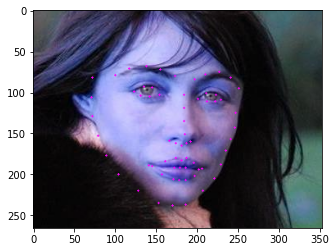

In [8]:
plt.imshow(cropped_pose_img)

In [9]:
mat = sio.loadmat("data/300W_LP/landmarks/AFW/AFW_1051618982_1_0_pts.mat")
mat["pts_2d"].shape

(68, 2)

In [10]:
mat = sio.loadmat("data/300W_LP/landmarks/HELEN/HELEN_100032540_1_0_pts.mat")
mat["pts_2d"].shape

(68, 2)